In [162]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="This documment is written in a Jupyter notebook and the code used to produce these analyses has been hidden for ease of reading.  
To make the code visiable click here"></form>''')

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import numpy
import scipy.constants as const

In [3]:
from ocelot.common.globals import *
from ocelot.adaptors.genesis import write_dfl_file
from ocelot.optics.wave import imitate_sase_dfl, wigner_dfl, dfl_waistscan
from ocelot.gui.genesis_plot import plot_dfl, plot_wigner, plot_dfl_waistscan

initializing ocelot...


In [4]:
from wpg import Wavefront, Beamline
from wpg.optical_elements import Drift
from wpg.optical_elements import Aperture
from wpg.optical_elements import Mirror_elliptical
from wpg.optical_elements import WF_dist
from wpg.optical_elements import calculateOPD
from wpg.optical_elements import Use_PP
from wpg.converters.genesis_v2 import vector_grid_conversion


#import SRW core functions
from wpg import srwlib
from wpg import srwlpy
from wpg.srwlib import srwl

##Gaussian beam generator
from wpg.generators import build_gauss_wavefront

from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import integral_intensity, plot_intensity_map,plot_intensity_qmap, check_sampling
from wpg.wpg_uti_oe import show_transmission

In [5]:
from matplotlib import pyplot
from matplotlib.pyplot import imshow

In [6]:
import lcls_amo_sirepo_raw

In [7]:
def convert_to_wpg_wavefront(radiation_field):

    # Needed constants.
    speed_of_light = const.codata.value('speed of light in vacuum')
    h_eV_s = const.codata.value('Planck constant in eV s')

    # Hard-code undulator period, should be read from genesis out object.
    lmb_und = 2.75e-2

    # Initialize empty wavefront.
    wf = Wavefront()

    # Extract geometry.
    slice_count = radiation_field.Nz()
    slice_spacing = radiation_field.dz
    wavelength = radiation_field.xlamds
    npoints = radiation_field.Nx()


    # Setup E-field.
    wf.data.arrEhor = numpy.zeros(shape=(npoints, npoints, slice_count, 2))
    wf.data.arrEver = numpy.zeros(shape=(npoints, npoints, slice_count, 2))

    # Fill in the fields of the wavefront object
    wf.params.wEFieldUnit = 'sqrt(W/mm^2)'
    wf.params.photonEnergy = h_eV_s * speed_of_light / wavelength
    wf.params.wDomain = 'time'
    wf.params.Mesh.nSlices = slice_count
    wf.params.Mesh.nx = npoints
    wf.params.Mesh.ny = npoints
    pulse_length = (slice_count - 1) * slice_spacing / (speed_of_light)
    wf.params.Mesh.sliceMin = -pulse_length / 2.
    wf.params.Mesh.sliceMax = pulse_length / 2.
    range_xy = radiation_field.Lx()
    wf.params.Mesh.xMin = -range_xy / 2.
    wf.params.Mesh.xMax = range_xy / 2.
    wf.params.Mesh.yMin = -range_xy / 2.
    wf.params.Mesh.yMax = range_xy / 2.


    print('Photon energy: ', wf.params.photonEnergy, 'eV')
    print('Pulse length: %4.3e' % ( pulse_length ))

    # Extract the field data and fill in the data of the Electric field, by calling the
    # vector_grid_conversion function
    wf.data.arrEhor = vector_grid_conversion(
        radiation_field.fld, npoints, slice_count, range_xy, wavelength, lmb_und)

    return wf

# No mirror height profile

## Import the AMO beamline

In [7]:
srwl_beamline = lcls_amo_sirepo_raw.set_optics()

![AMO Beamline geometry](AMO_setup.png "The AMO beamline at LCLS")

![AMO beamline](amo-schematic.png)

## Gaussian wavefront

In [10]:
# Gaussian wavefront builder
np = 700
nslices = 100
photon_energy = 1.6e3
theta_fwhm = 6.0e-6 ### ADJUST ME

wlambda = 1.24*1e-6/photon_energy # wavelength [AKM]
w0 = wlambda/(numpy.pi*theta_fwhm) # beam waist
zR = (numpy.pi*w0**2)/wlambda #Rayleigh range
fwhm_at_zR = theta_fwhm*zR #FWHM at Rayleigh range
sigmaAmp = w0/(2*numpy.sqrt(numpy.log(2))) #sigma of amplitude
src_to_aperture_distance = 170.0
pulse_energy = 4e-4 # [J]

# Coherence time
pulse_duration = 30.0e-15 # [s]
coh_time = pulse_duration/10.0     # estimate, [s]


# Print out the calculated wavefront parameters and expected FWHM
print ('######################')
print ('# Beam size report   #')
print('# theta_fwhm:\t{:.2f}urad'.format(theta_fwhm*1e6))
print('# fwhm waist:\t{:.1f}um'.format(w0*1e6))
print('# lambda:\t{:.2f}nm'.format(wlambda*1e9))
print('# 2*z_R:\t{:.1f}m'.format(2*zR))
print('# sigma for amplitude:\t{:.1f}um'.format(sigmaAmp*1e6))
#
print('# expected FWHM at distance {:.1f}m is {:.1f}mm'.format(src_to_aperture_distance,theta_fwhm*src_to_aperture_distance*1e3))
print ('######################')

# expected beam radius at HOM1 position to get the range of the wavefront
range_xy = w0*numpy.sqrt(1+(src_to_aperture_distance/zR)**2) *5.5

######################
# Beam size report   #
# theta_fwhm:	6.00urad
# fwhm waist:	41.1um
# lambda:	0.78nm
# 2*z_R:	13.7m
# sigma for amplitude:	24.7um
# expected FWHM at distance 170.0m is 1.0mm
######################


In [11]:
srwl_wf = build_gauss_wavefront(np, np, nslices, photon_energy/1e3, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/numpy.sqrt(2),
                                sigmaAmp, sigmaAmp, src_to_aperture_distance,
                                pulseEn=pulse_energy, pulseRange=8.)

R-space
(700,) (700,)
FWHM in x = 9.946e-04 m.
FWHM in y = 9.946e-04 m.


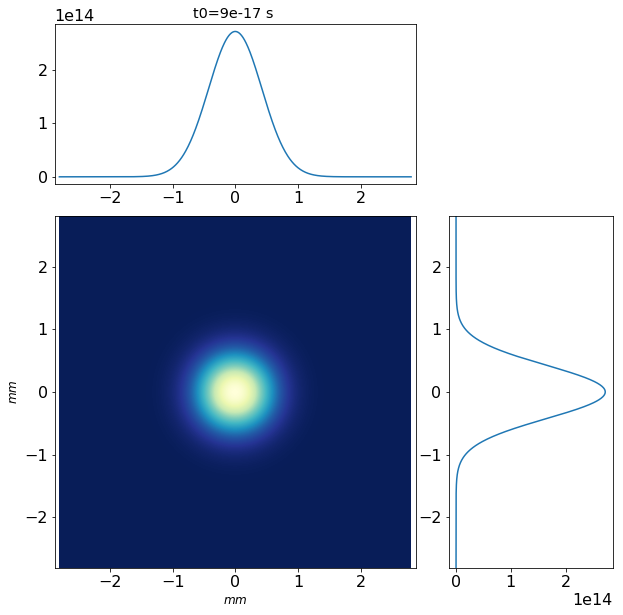

In [10]:
plot_intensity_map(Wavefront(srwl_wavefront=srwl_wf))

In [11]:
wavefront_check = check_sampling(Wavefront(srwl_wavefront=srwl_wf))
print(wavefront_check)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|9.946e-04|8.032e-06|5.615e-03|1.700e+02|6.618e-05|5.623e-05|8.032e-05|
|Vertical  |9.946e-04|8.032e-06|5.615e-03|1.700e+02|6.618e-05|5.623e-05|8.032e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension within [7,10]*pixel_width -> OK
Vertical Fresnel zone extension within [7,10]*pixel_height -> OK
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


### Propagate through beamline

In [12]:
srwl.SetRepresElecField( srwl_wf, 'f')

srwl.PropagElecField(srwl_wf, srwl_beamline)

srwl.SetRepresElecField( srwl_wf, 't')

In [13]:
wavefront_report = check_sampling(Wavefront(srwl_wf)); print(wavefront_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|6.729e-07|1.532e-08|1.071e-05|6.263e-05|3.604e-08|1.072e-07|1.532e-07|
|Vertical  |4.544e-07|1.058e-08|7.398e-06|2.943e-05|2.507e-08|7.409e-08|1.058e-07|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


R-space
(700,) (700,)
FWHM in x = 6.729e-07 m.
FWHM in y = 4.544e-07 m.


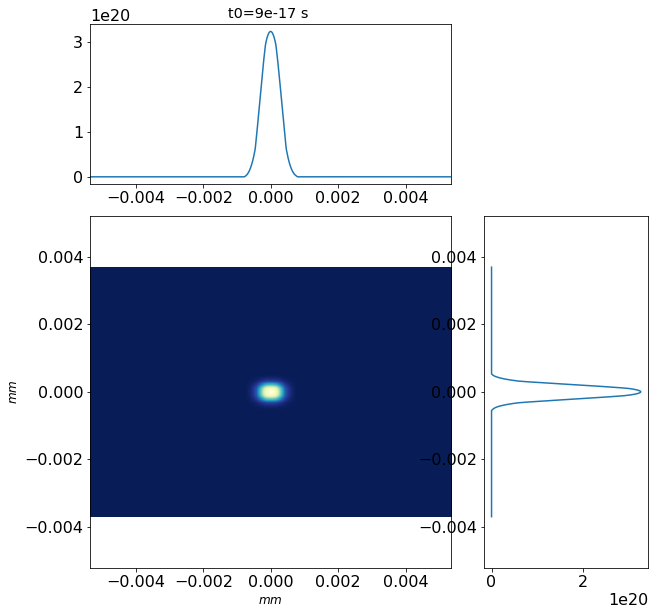

In [14]:
plot_intensity_map(Wavefront(srwl_wavefront=srwl_wf))

## SASE pulse

In [15]:
dfl = imitate_sase_dfl(h_eV_s * speed_of_light / photon_energy,
                       rho=2e-4,
                       shape=(700,700,300),
                       dgrid=(5e-3,5e-3, 6.0*speed_of_light*pulse_duration),
                       power_rms=(20e-6,20e-6,0.5*speed_of_light*pulse_duration), 
                       power_center=(0,0,None),
                       power_angle=(0,0),
                       power_waistpos=(0,0),
                       wavelength=None,
                       zsep=None, 
                       freq_chirp=0,
                       en_pulse=None,
                       power=1e6,
                      )

dfl.prop(170.0)

[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


In [16]:
sase_wf = convert_to_wpg_wavefront(dfl)

Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


In [17]:
sase_wf.store_hdf5("sase_model_wf_1.6ekV.hdf5")

R-space
(700,) (700,)
FWHM in x = 1.243e-03 m.
FWHM in y = 1.243e-03 m.


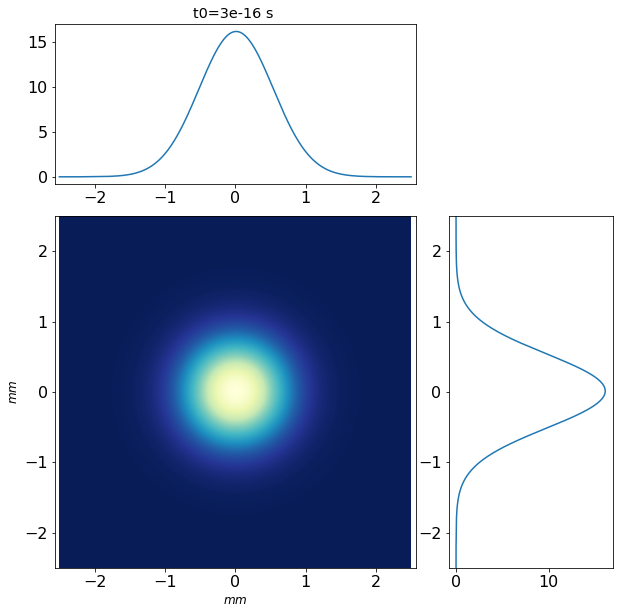

In [18]:
plot_intensity_map(sase_wf)

Q-space
{'fwhm_y': 7.263028936974946e-06, 'fwhm_x': 7.263028936974946e-06}
Q-space
(700,) (700,)


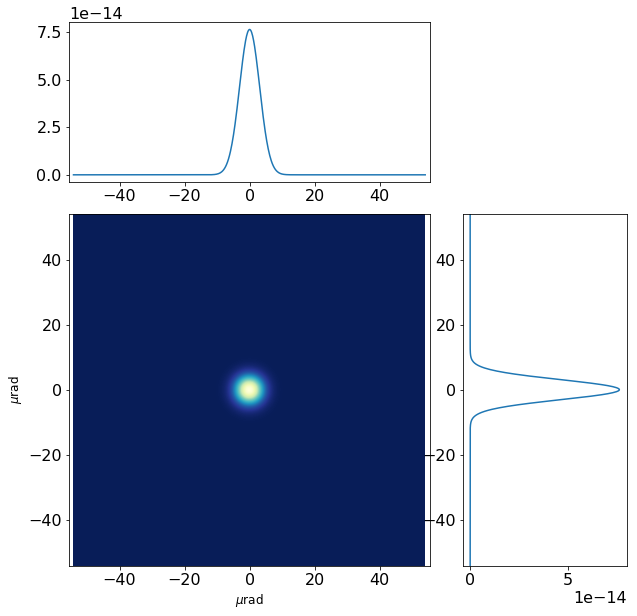

In [19]:
plot_intensity_qmap(sase_wf)

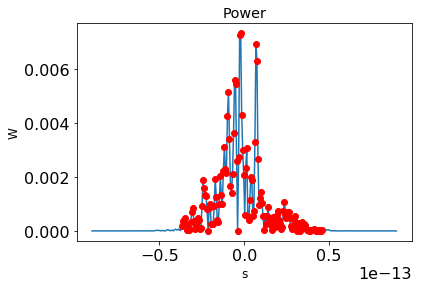

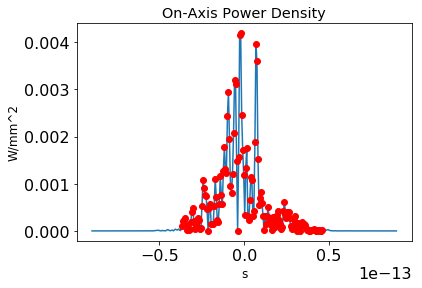

number of meaningful slices: 139
Pulse energy 9.1e-17 J


0.0010903488389022058

In [20]:
integral_intensity(sase_wf)

In [21]:
sampling_report = check_sampling(sase_wf); print(sampling_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.243e-03|7.153e-06|5.000e-03|0.000e+00|0.000e+00|5.007e-05|7.153e-05|
|Vertical  |1.243e-03|7.153e-06|5.000e-03|0.000e+00|0.000e+00|5.007e-05|7.153e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI !> 3* FWHM(x) -> Increase ROI width (x).
Horizontal ROI !> 3* FWHM(y) -> Increase ROI height (y).
Focus sampling: FWHM > 10*px

END OF REPORT


### Fix wavefront curvature

In [22]:
sase_wf._srwl_wf.Rx = 170.0
sase_wf._srwl_wf.Ry = 170.0

In [26]:
sampling_report = check_sampling(sase_wf); print(sampling_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|5.442e-07|8.934e-09|6.245e-06|6.263e-05|4.456e-08|6.254e-08|8.934e-08|
|Vertical  |3.697e-07|6.170e-09|4.313e-06|2.943e-05|3.082e-08|4.319e-08|6.170e-08|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


### Propagate through beamline

In [23]:
srwl.SetRepresElecField( sase_wf._srwl_wf, 'f')

srwl.PropagElecField(sase_wf._srwl_wf, srwl_beamline)

srwl.SetRepresElecField( srwl_wf, 't')

### Diagnostics

In [24]:
print(check_sampling(sase_wf))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|5.442e-07|8.934e-09|6.245e-06|6.263e-05|4.456e-08|6.254e-08|8.934e-08|
|Vertical  |3.697e-07|6.170e-09|4.313e-06|2.943e-05|3.082e-08|4.319e-08|6.170e-08|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


R-space
(700,) (700,)
FWHM in x = 5.442e-07 m.
FWHM in y = 3.697e-07 m.


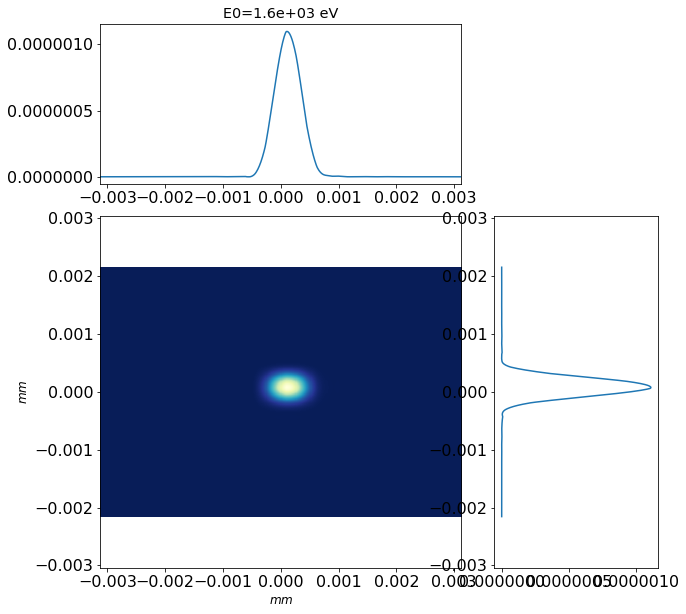

In [25]:
plot_intensity_map(sase_wf)

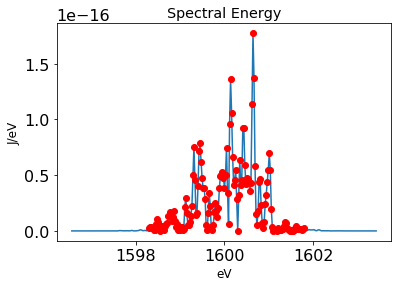

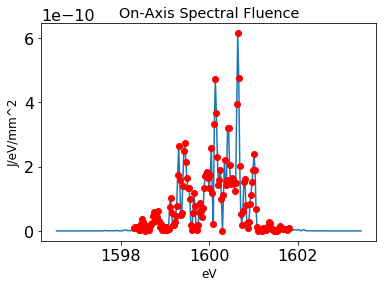

number of meaningful slices: 153


2.49068598737733e-17

In [27]:
integral_intensity(sase_wf)

# With mirror height profile

## Import the AMO beamline

In [9]:
srwl_beamline_with_profile = lcls_amo_sirepo_raw.set_optics(mirror_profile="mirror_2d.dat")

![AMO Beamline geometry](AMO_setup.png "The AMO beamline at LCLS")

![AMO beamline](amo-schematic.png)

## Gaussian wavefront

R-space
(700,) (700,)
FWHM in x = 9.946e-04 m.
FWHM in y = 9.946e-04 m.


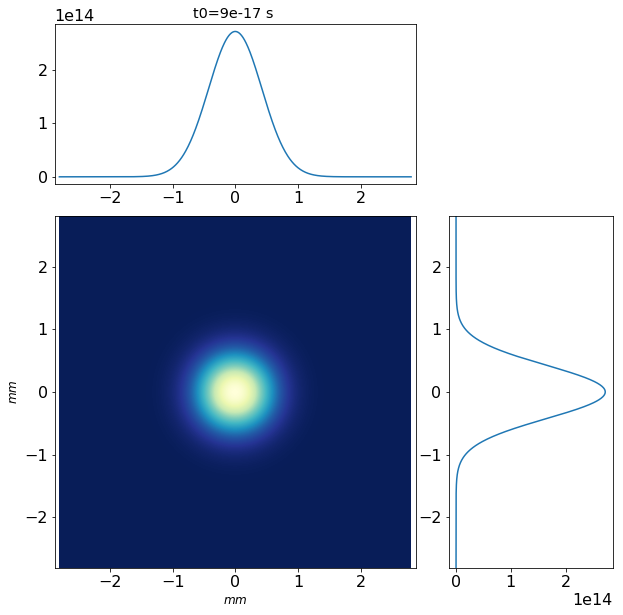

In [12]:
plot_intensity_map(Wavefront(srwl_wavefront=srwl_wf))

In [13]:
wavefront_check = check_sampling(Wavefront(srwl_wavefront=srwl_wf))
print(wavefront_check)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|9.946e-04|8.032e-06|5.615e-03|1.700e+02|6.618e-05|5.623e-05|8.032e-05|
|Vertical  |9.946e-04|8.032e-06|5.615e-03|1.700e+02|6.618e-05|5.623e-05|8.032e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension within [7,10]*pixel_width -> OK
Vertical Fresnel zone extension within [7,10]*pixel_height -> OK
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


### Propagate through beamline

In [14]:
srwl.SetRepresElecField( srwl_wf, 'f')

srwl.PropagElecField(srwl_wf, srwl_beamline_with_profile)

srwl.SetRepresElecField( srwl_wf, 't')

In [15]:
wavefront_report = check_sampling(Wavefront(srwl_wf)); print(wavefront_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|7.800e-07|1.532e-08|1.071e-05|6.263e-05|3.109e-08|1.072e-07|1.532e-07|
|Vertical  |5.179e-07|1.058e-08|7.398e-06|2.943e-05|2.200e-08|7.409e-08|1.058e-07|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


R-space
(700,) (700,)
FWHM in x = 7.800e-07 m.
FWHM in y = 5.179e-07 m.


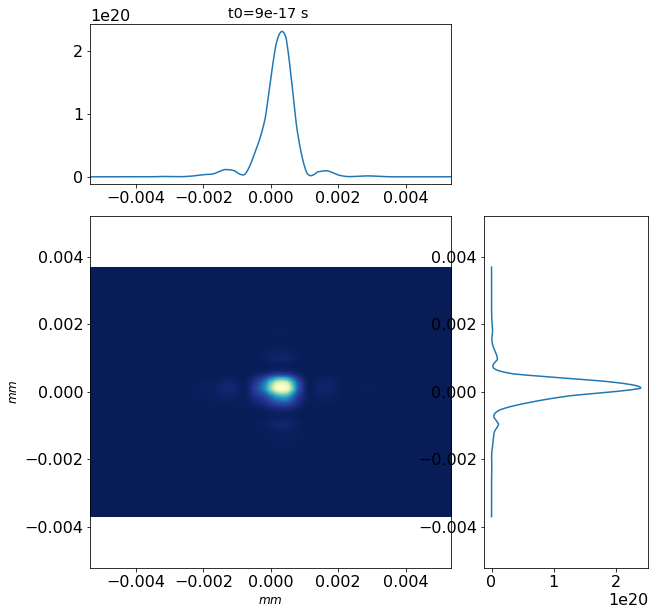

In [16]:
plot_intensity_map(Wavefront(srwl_wavefront=srwl_wf))

## SASE pulse

In [17]:
dfl = imitate_sase_dfl(h_eV_s * speed_of_light / photon_energy,
                       rho=2e-4,
                       shape=(700,700,300),
                       dgrid=(5e-3,5e-3, 6.0*speed_of_light*pulse_duration),
                       power_rms=(20e-6,20e-6,0.5*speed_of_light*pulse_duration), 
                       power_center=(0,0,None),
                       power_angle=(0,0),
                       power_waistpos=(0,0),
                       wavelength=None,
                       zsep=None, 
                       freq_chirp=0,
                       en_pulse=None,
                       power=1e6,
                      )

dfl.prop(170.0)

[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


In [18]:
sase_wf = convert_to_wpg_wavefront(dfl)

Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


R-space
(700,) (700,)
FWHM in x = 1.243e-03 m.
FWHM in y = 1.243e-03 m.


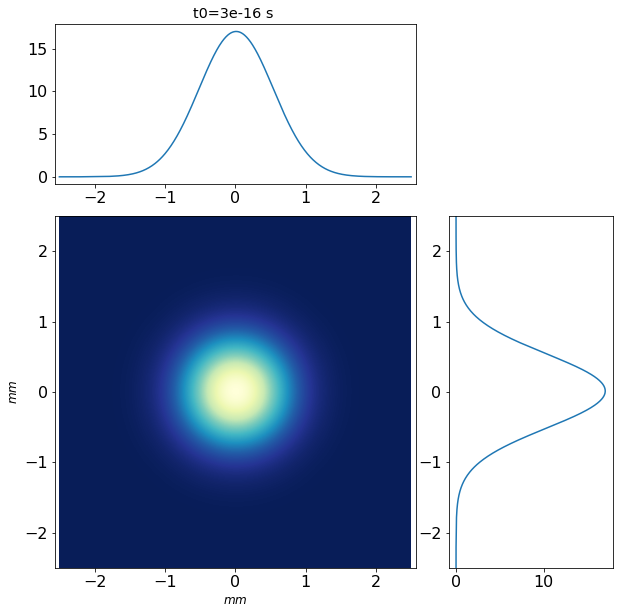

In [19]:
plot_intensity_map(sase_wf)

Q-space
{'fwhm_y': 7.263028936974946e-06, 'fwhm_x': 7.263028936974946e-06}
Q-space
(700,) (700,)


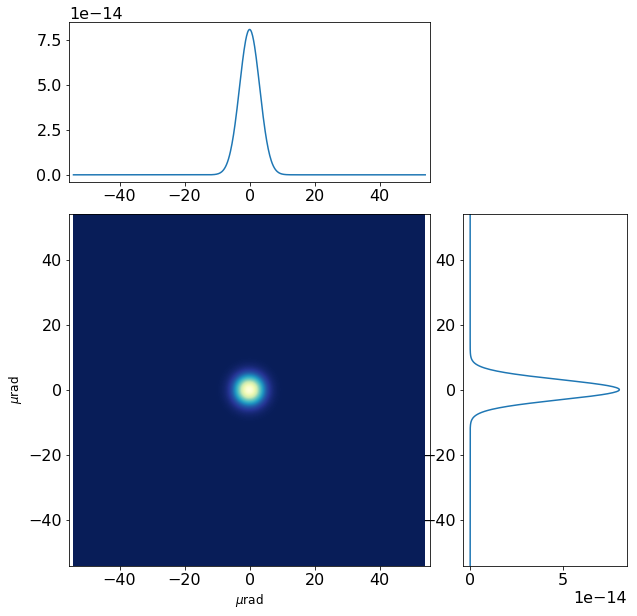

In [20]:
plot_intensity_qmap(sase_wf)

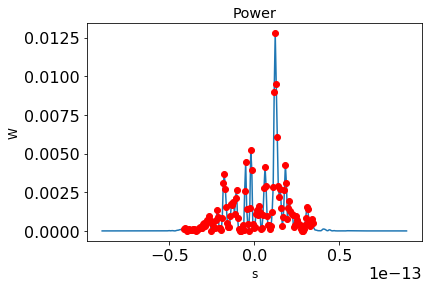

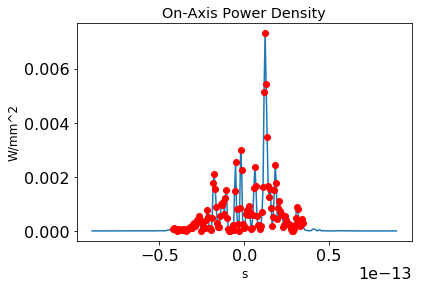

number of meaningful slices: 128
Pulse energy 9.5e-17 J


0.0012427216861397028

In [21]:
integral_intensity(sase_wf)

In [22]:
sampling_report = check_sampling(sase_wf); print(sampling_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.243e-03|7.153e-06|5.000e-03|0.000e+00|0.000e+00|5.007e-05|7.153e-05|
|Vertical  |1.243e-03|7.153e-06|5.000e-03|0.000e+00|0.000e+00|5.007e-05|7.153e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI !> 3* FWHM(x) -> Increase ROI width (x).
Horizontal ROI !> 3* FWHM(y) -> Increase ROI height (y).
Focus sampling: FWHM > 10*px

END OF REPORT


### Fix wavefront curvature

In [23]:
sase_wf._srwl_wf.Rx = 170.0
sase_wf._srwl_wf.Ry = 170.0

In [24]:
sampling_report = check_sampling(sase_wf); print(sampling_report)

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.243e-03|7.153e-06|5.000e-03|1.700e+02|5.296e-05|5.007e-05|7.153e-05|
|Vertical  |1.243e-03|7.153e-06|5.000e-03|1.700e+02|5.296e-05|5.007e-05|7.153e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension within [7,10]*pixel_width -> OK
Vertical Fresnel zone extension within [7,10]*pixel_height -> OK
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


### Propagate through beamline

In [25]:
srwl.SetRepresElecField( sase_wf._srwl_wf, 'f')

srwl.PropagElecField(sase_wf._srwl_wf, srwl_beamline_with_profile)

srwl.SetRepresElecField( srwl_wf, 't')

### Diagnostics

In [26]:
print(check_sampling(sase_wf))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|6.602e-07|8.934e-09|6.245e-06|6.263e-05|3.673e-08|6.254e-08|8.934e-08|
|Vertical  |4.621e-07|6.170e-09|4.313e-06|2.943e-05|2.466e-08|4.319e-08|6.170e-08|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


R-space
(700,) (700,)
FWHM in x = 6.602e-07 m.
FWHM in y = 4.621e-07 m.


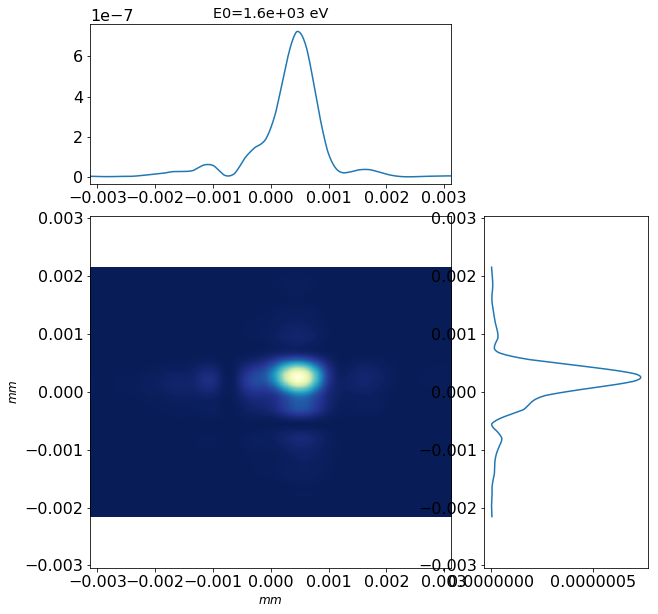

In [27]:
plot_intensity_map(sase_wf)

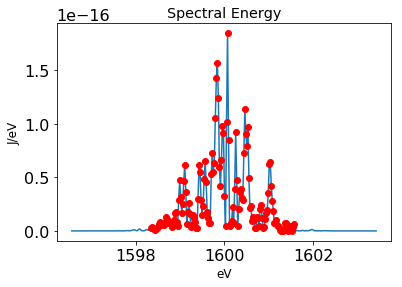

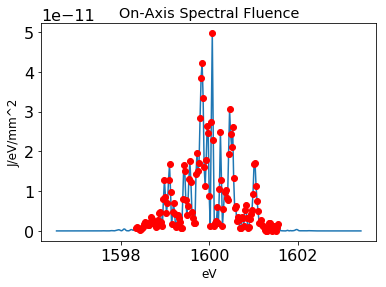

number of meaningful slices: 141


2.823769956041502e-17

In [28]:
integral_intensity(sase_wf)

In [64]:
print("prop_out_%07d" % (23))

prop_out_0000023


In [65]:
# Production run (100 shots)

for i in range(100):
    dfl = imitate_sase_dfl(h_eV_s * speed_of_light / photon_energy,
                       rho=2e-4,
                       shape=(700,700,300),
                       dgrid=(5e-3,5e-3, 6.0*speed_of_light*pulse_duration),
                       power_rms=(20e-6,20e-6,0.5*speed_of_light*pulse_duration), 
                       power_center=(0,0,None),
                       power_angle=(0,0),
                       power_waistpos=(0,0),
                       wavelength=None,
                       zsep=None, 
                       freq_chirp=0,
                       en_pulse=None,
                       power=1e6,
                      )

    dfl.prop(170.0)

    sase_wf = convert_to_wpg_wavefront(dfl)

    sase_wf._srwl_wf.Rx = 170.0
    sase_wf._srwl_wf.Ry = 170.0

    srwl.SetRepresElecField( sase_wf._srwl_wf, 'f')
    srwl.PropagElecField(sase_wf._srwl_wf, srwl_beamline_with_profile)
    srwl.SetRepresElecField( sase_wf._srwl_wf, 't')
    
    sase_wf.store_hdf5("prop_out_%07d.h5" % (i))
    
    del sase_wf
    sase_wf = None
    
    del dfl
    dfl = None
    

[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


[INFO    ] imitating SASE radiation
[INFO    ] : generating radiation field of shape(300, 700, 700)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] propagating dfl file by 170.00 meters
[INFO    ] : transforming radiation field to k domain
[INFO    ] : transforming radiation field to ('t', 's') domain


Photon energy:  1599.9999998683977 eV
Pulse length: 1.793e-13


In [66]:
!ls

amo_propagaton.odp
amo_schematic.odp
amo-schematic.png
AMO_setup.flat.pdf
AMO_setup.pdf
AMO_setup.png
Ferguson_et_al-2015-Journal_of_Synchrotron_Radiation.pdf
KB 1.6-101-r0.pdf
lcls_amo86615.ipynb
lcls_amo_beamline.py
lcls_amo_sirepo_raw.py
mirror_2d.dat
prop_out_0000000.h5
prop_out_0000001.h5
prop_out_0000002.h5
prop_out_0000003.h5
prop_out_0000004.h5
prop_out_0000005.h5
prop_out_0000006.h5
prop_out_0000007.h5
prop_out_0000008.h5
prop_out_0000009.h5
prop_out_0000010.h5
prop_out_0000011.h5
prop_out_0000012.h5
prop_out_0000013.h5
prop_out_0000014.h5
prop_out_0000015.h5
prop_out_0000016.h5
prop_out_0000017.h5
prop_out_0000018.h5
prop_out_0000019.h5
prop_out_0000020.h5
prop_out_0000021.h5
prop_out_0000022.h5
prop_out_0000023.h5
prop_out_0000024.h5
prop_out_0000025.h5
prop_out_0000026.h5
prop_out_0000027.h5
prop_out_0000028.h5
prop_out_0000029.h5
prop_out_0000030.h5
prop_out_0000031.h5
prop_out_0000032.h5
prop_out_0000033.h5
prop_out_0000034.h5
prop_out_0000035.h5
prop_out_0000036.h5
prop_

# Pulse analysis

In [135]:
def center_of_mass_and_rms(intensity_profile):
    
    x_grid = numpy.arange(intensity_profile.shape[0])
    y_grid = numpy.arange(intensity_profile.shape[1])
    mesh = numpy.meshgrid(x_grid, y_grid)

    center_of_gravity_x, center_of_gravity_y = [s.sum() for s in intensity_profile*mesh/intensity_profile.sum()]
    

    px_rms_x =  numpy.sqrt((intensity_profile*(mesh[0])**2/intensity_profile.sum()).sum() - center_of_gravity_x**2)
    px_rms_y =  numpy.sqrt((intensity_profile*(mesh[1])**2/intensity_profile.sum()).sum() - center_of_gravity_y**2)

    return ((center_of_gravity_x, center_of_gravity_y), (px_rms_x, px_rms_y))

In [136]:
def time_moments(intensity_profile):
    
    grid = numpy.arange(intensity_profile.shape[0])

    center_of_gravity  = numpy.sum(intensity_profile * grid) / numpy.sum(intensity_profile)
    

    px_rms =  numpy.sqrt(numpy.sum(intensity_profile*(grid)**2)/numpy.sum(intensity_profile) - center_of_gravity**2)
   

    return (center_of_gravity, px_rms)

In [141]:
def process_moments(i):

    wavefront = Wavefront()
    wavefront.load_hdf5(os.path.join('prop_out','prop_out_%07d.h5' % (i)))
    
    xMin = wavefront.params.Mesh.xMin
    xMax = wavefront.params.Mesh.xMax
    yMin = wavefront.params.Mesh.yMin
    yMax = wavefront.params.Mesh.yMax
    tMin = wavefront.params.Mesh.sliceMin
    tMax = wavefront.params.Mesh.sliceMax
    
    nx = wavefront.params.Mesh.nx
    ny = wavefront.params.Mesh.ny
    nt = wavefront.params.Mesh.nSlices;
    
    dx = (xMax-xMin)/(nx-1)
    dy = (yMax-yMin)/(ny-1)
    dt = (tMax-tMin)/(nt-1)

    intensity = wavefront.get_intensity().sum(axis=-1)
    
    xy_moments = center_of_mass_and_rms(wavefront.get_intensity().sum(axis=-1))
    t_moments = time_moments(wavefront.get_intensity().sum(axis=(0,1)))
    
    return numpy.array([[xy_moments[0][0]*dx,xy_moments[0][1]*dy,t_moments[0]*dt],[xy_moments[1][0]*dx, xy_moments[1][1]*dy,t_moments[1]*dt]])

In [155]:
moments = [process_moments(i) for i in range(100)]

In [156]:
moments = numpy.array(moments)

In [157]:
com_x = moments[:,0,0]
com_y = moments[:,0,1]
com_t = moments[:,0,2]
rms_x = moments[:,1,0]
rms_y = moments[:,1,1]
rms_t = moments[:,1,2]

## Pulse beam center (center of gravity) as function of shot number

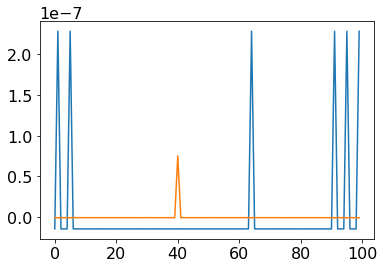

In [158]:
pyplot.plot(com_x-com_x.mean())
pyplot.plot(com_y-com_y.mean())
pyplot.show()

## Pulse beam size (rms) as function of shot number

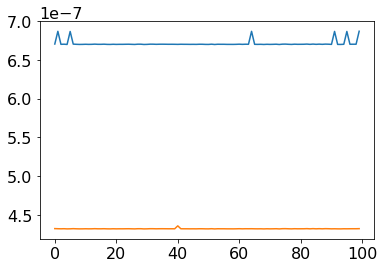

In [159]:
pyplot.plot(rms_x)
pyplot.plot(rms_y)
pyplot.show()

## Pulse central time (center of gravity) as function of shot number

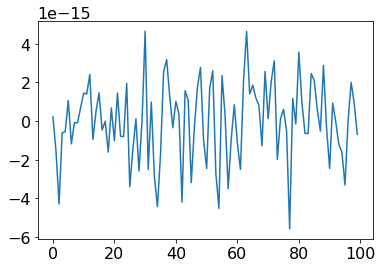

In [160]:
pyplot.plot(com_t-com_t.mean())
pyplot.show()

## Pulse duration (rms) as function of shot number

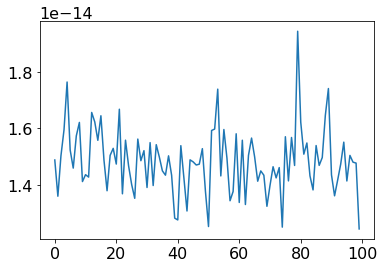

In [161]:
pyplot.plot(rms_t)
pyplot.show()